Simulation Start
Simulation End


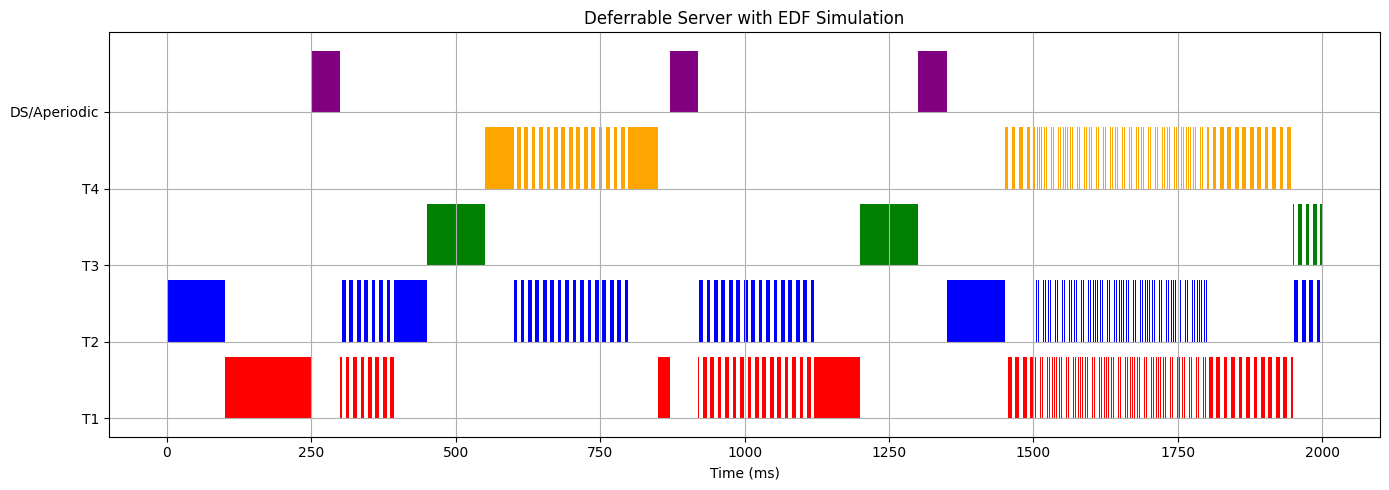

In [2]:
import heapq
import matplotlib.pyplot as plt

# Parameters
WCET = {'T1': 200, 'T2': 100, 'T3': 100, 'T4': 200}
DEADLINE = {'T1': 600, 'T2': 300, 'T3': 700, 'T4': 900}
PERIOD = DEADLINE.copy()

# Deferrable Server parameters
DS_PERIOD = 500
DS_BUDGET = 100
DS_NEXT_RELEASE = 0
DS_REMAINING_BUDGET = DS_BUDGET

# Aperiodic task queue
aperiodic_requests = [ (250, 'A1'), (870, 'A2'), (1300, 'A3') ]  # (arrival_time, name)
aperiodic_queue = []

# Simulation tracking
time = 0
simulation_end = 2000
ready_queue = []
task_log = []

# Next release tracker
next_release = {name: 0 for name in WCET}

class Task:
    def __init__(self, name, release_time, deadline, wcet):
        self.name = name
        self.release_time = release_time
        self.deadline = deadline
        self.remaining_time = wcet

    def __lt__(self, other):
        return self.deadline < other.deadline

print("Simulation Start")

while time < simulation_end:
    # === 1. Release periodic tasks ===
    for task_name in WCET:
        if time == next_release[task_name]:
            task = Task(task_name, time, time + DEADLINE[task_name], WCET[task_name])
            heapq.heappush(ready_queue, task)
            next_release[task_name] += PERIOD[task_name]

    # === 2. Release aperiodic tasks ===
    while aperiodic_requests and aperiodic_requests[0][0] == time:
        _, name = aperiodic_requests.pop(0)
        aperiodic_queue.append(Task(name, time, float('inf'), 50))  # assume 50ms WCET

    # === 3. Reset DS budget on new period ===
    if time == DS_NEXT_RELEASE:
        DS_REMAINING_BUDGET = DS_BUDGET
        DS_NEXT_RELEASE += DS_PERIOD

    executed = False

    # === 4. Serve aperiodic if budget and task exists ===
    if DS_REMAINING_BUDGET > 0 and aperiodic_queue:
        task = aperiodic_queue[0]
        exec_time = min(task.remaining_time, 1, DS_REMAINING_BUDGET)
        task_log.append((time, time + exec_time, task.name))
        task.remaining_time -= exec_time
        DS_REMAINING_BUDGET -= exec_time
        if task.remaining_time <= 0:
            aperiodic_queue.pop(0)
        executed = True

    # === 5. Serve periodic task via EDF ===
    if not executed and ready_queue:
        task = heapq.heappop(ready_queue)
        exec_time = min(task.remaining_time, 1)
        task_log.append((time, time + exec_time, task.name))
        task.remaining_time -= exec_time
        if task.remaining_time > 0:
            heapq.heappush(ready_queue, task)

    time += 1

print("Simulation End")

# === Visualization ===
colors = {'T1': 'red', 'T2': 'blue', 'T3': 'green', 'T4': 'orange', 'A1': 'purple', 'A2': 'purple', 'A3': 'purple'}

fig, ax = plt.subplots(figsize=(14, 5))
for start, end, task in task_log:
    y = 10 * (int(task[1]) if task.startswith('T') else 5)
    ax.broken_barh([(start, end - start)], (y, 8), facecolors=colors.get(task, 'gray'))

ax.set_xlabel("Time (ms)")
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels(['T1', 'T2', 'T3', 'T4', 'DS/Aperiodic'])
ax.grid(True)
plt.title("Deferrable Server with EDF Simulation")
plt.tight_layout()
plt.show()


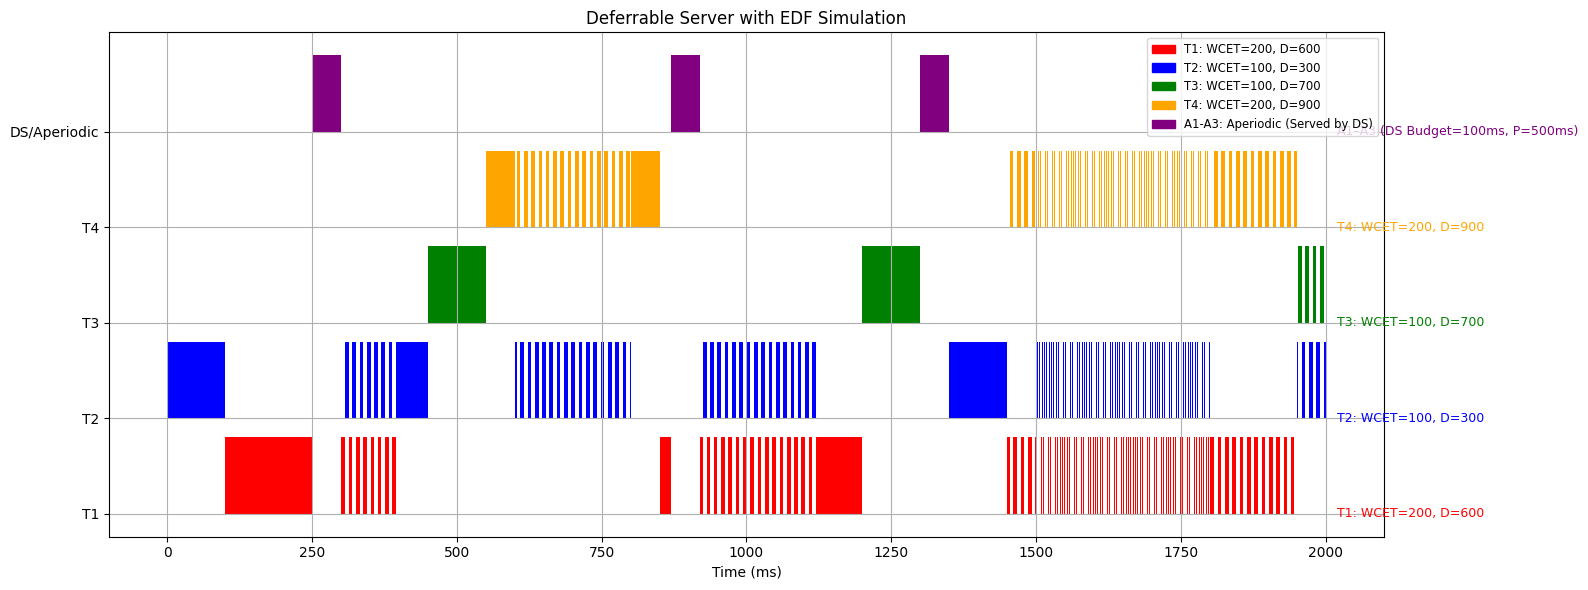

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Colors and task definitions
colors = {
    'T1': 'red',
    'T2': 'blue',
    'T3': 'green',
    'T4': 'orange',
    'A1': 'purple',
    'A2': 'purple',
    'A3': 'purple'
}

# Gantt chart plot
fig, ax = plt.subplots(figsize=(16, 6))
for start, end, task in task_log:
    y = 10 * (int(task[1]) if task.startswith('T') else 5)
    ax.broken_barh([(start, end - start)], (y, 8), facecolors=colors.get(task, 'gray'))

# Label axis
ax.set_xlabel("Time (ms)")
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels(['T1', 'T2', 'T3', 'T4', 'DS/Aperiodic'])
ax.grid(True)
plt.title("Deferrable Server with EDF Simulation")

# Legend
legend_patches = [
    mpatches.Patch(color='red', label='T1: WCET=200, D=600'),
    mpatches.Patch(color='blue', label='T2: WCET=100, D=300'),
    mpatches.Patch(color='green', label='T3: WCET=100, D=700'),
    mpatches.Patch(color='orange', label='T4: WCET=200, D=900'),
    mpatches.Patch(color='purple', label='A1-A3: Aperiodic (Served by DS)')
]
ax.legend(handles=legend_patches, loc='upper right', fontsize='small')

# Optional: Add textual descriptions near bars
ax.text(2020, 10, "T1: WCET=200, D=600", color='red', va='center', fontsize=9)
ax.text(2020, 20, "T2: WCET=100, D=300", color='blue', va='center', fontsize=9)
ax.text(2020, 30, "T3: WCET=100, D=700", color='green', va='center', fontsize=9)
ax.text(2020, 40, "T4: WCET=200, D=900", color='orange', va='center', fontsize=9)
ax.text(2020, 50, "A1–A3 (DS Budget=100ms, P=500ms)", color='purple', va='center', fontsize=9)

plt.tight_layout()
plt.show()
